We aim to use `RADAR` to do differential analysis of m6A peaks.

I needed to re-build `STAR` indices as I've described in my notebook at `genomes/build-genome.ipynb` (see rumi and my GitHub repo). 

In [12]:
cat star.sh

mkdir -p bam
mkdir -p qc_star

STAR --genomeLoad LoadAndExit --genomeDir ~/genomes/hg38/gencode.v34/star_index

for fq in fastq/*R1*; do
    fq=`basename $fq`
    echo '------------' $fq '-----------'
    out=${fq/_S*/}
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 18 \
    --genomeDir ~/genomes/hg38/gencode.v34/star_index \
    --readFilesIn fastq/$fq \
    --outFileNamePrefix bam/$out
done

STAR --genomeLoad Remove --genomeDir ~/genomes/hg38/gencode.v34/star_index

rm -vr _STARtmp/ Aligned.out.sam Log.out Log.progress.out



In [11]:
ls bam/

T1.input.bam      T2.input.bam      U1.input.bam      U2.input.bam
T1.input.bam.bai  T2.input.bam.bai  U1.input.bam.bai  U2.input.bam.bai
T1.m6A.bam        T2.m6A.bam        U1.m6A.bam        U2.m6A.bam
T1.m6A.bam.bai    T2.m6A.bam.bai    U1.m6A.bam.bai    U2.m6A.bam.bai


In [20]:
cat star.out

Jun 21 10:18:35 ..... started STAR run
Jun 21 10:18:35 ..... loading genome

EXITING because of FATAL ERROR: waited too long for the other job to finish loading the genomeSuccess
SOLUTION: remove the shared memory chunk by running STAR with --genomeLoad Remove, and restart STAR
Jun 21 11:58:35 ...... FATAL ERROR, exiting
------------ Input_T1_S43_L006_R1_001.fastq.gz -----------
Jun 21 11:58:35 ..... started STAR run
Jun 21 11:58:36 ..... loading genome
Jun 21 11:59:01 ..... started mapping
Jun 21 12:00:47 ..... finished mapping
Jun 21 12:00:49 ..... started sorting BAM
Jun 21 12:02:00 ..... finished successfully
------------ Input_T2_S44_L006_R1_001.fastq.gz -----------
Jun 21 12:03:14 ..... started STAR run
Jun 21 12:03:14 ..... loading genome
Jun 21 12:03:37 ..... started mapping
Jun 21 12:05:20 ..... finished mapping
Jun 21 12:05:23 ..... started sorting BAM
Jun 21 12:06:31 ..... finished successfully
------------ Input_U1_S41_L006_R1_001.fastq.gz -----------
Jun 21 12:07:56 ..... 

In [16]:
%reload_ext rpy2.ipython

In [18]:
%%R 
library(RADAR)

In [4]:
%%R 
radar <- countReads(
	samplenames=c('T1','T2','U1','U2'), gtf = GTF,
	bamFolder='./bam/',modification = "m6A", strandToKeep = "opposite",outputDir='radar', threads = 18
)

Reading gtf file to obtain gene model
Filter out ambiguous model...


R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 36.3501307964325 mins... 


In [5]:
%%R 
saveRDS(radar, 'radar/raw.rds')

In [6]:
%%R
## save pictures 
pdf('plots/boxPlot.pdf')
radar <- normalizeLibrary(radar)
dev.off()
png('plots/boxPlot.png')
radar <- normalizeLibrary(radar)
dev.off()

png 
  2 


Ok, let's read the raw data again for downstream analysis:

In [1]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(RADAR)

In [9]:
%%R 
radar <- readRDS('radar/raw.rds')
radar <- normalizeLibrary(radar, boxPlot=0)

radar <- adjustExprLevel(radar)
# radar <- adjustExprLevel(radar, adjustBy = "pos")

# If you expect intensive alternative splicing events cross the experimental groups, 
# using gene-level read counts to represent pre-IP RNA level could leads to bias. 
# Therefore, the user can also choose to use the local bin-level read count to adjust 
# the pre-IP RNA level variation

variable(radar) <- data.frame( group = c(rep("T",2),rep("U",2)) )

radar <- filterBins(radar,minCountsCutOff = 15)

radar <- diffIP_parallel(radar,thread = 18)

radar <- reportResult(radar, cutoff = 1.1, Beta_cutoff = 0.00, threads=18)

saveRDS(radar, 'radar/final.all.rds')

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
T T U U 
0 0 1 1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.853114835421244 mins... 

Hyper-thread registered: TRUE 
Using 15 thread(s) to report merged report...
Time used to report peaks: 5.94898326396942 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 45566 reported differential loci at FDR < 1.1 and logFoldChange > 0.


## PCA analysis

In [64]:
%%R 
radar <- readRDS('radar/final.all.rds')
top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],] 
## save pictures 
png('plots/PCAPlot.png')
plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )
dev.off()
pdf('plots/PCAPlot.pdf')
plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )
dev.off()

Returning normalized IP read counts.
Returning normalized IP read counts.
png 
  2 


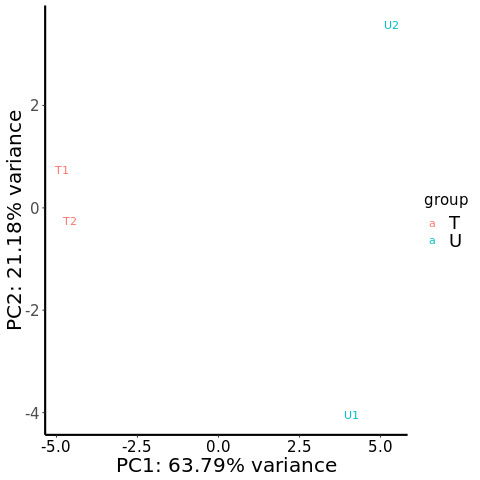

In [65]:
%%R 
plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )

# Get results 

In [19]:
%%R -o result.all 
radar <- readRDS('radar/final.all.rds') 
result.all <- results(radar)

There are 45566 reported differential loci at FDR < 1.1 and logFoldChange > 0.


> Due to the resolution of the MeRIP-seq experiment where RNA molecules are fragmented into 100-300nt, neighboring bins can usually contain reads from the same locus. Therefore, we do a post-processing to merge significant neighboring bins after the test to obtain a final list of differential peaks. We merge the p-value of connecting bins by fisher’s method and report the max beta from neighbouring bins.

Here, we use FDR<0.1 and log fold change > 0.5 as default cutoff for selecting significant bins

In [19]:
%%R 
radar.cut <- readRDS('radar/raw.rds')
radar.cut <- normalizeLibrary(radar.cut, boxPlot=0)

radar.cut <- adjustExprLevel(radar.cut)
# radar <- adjustExprLevel(radar, adjustBy = "pos")

variable(radar.cut) <- data.frame( group = c(rep("T",2),rep("U",2)) )

radar.cut <- filterBins(radar.cut,minCountsCutOff = 15)
radar.cut <- diffIP_parallel(radar.cut,thread = 18)

radar.cut <- reportResult(radar.cut, cutoff = 0.1, Beta_cutoff = 0.5, threads=18)
saveRDS(radar.cut, 'radar/final.rds')

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
T T U U 
0 0 1 1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.802650801340739 mins... 

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.792994467417399 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.


In [20]:
%%R -o result.sig
radar.cut <- readRDS('radar/final.rds')
result.sig = results(radar.cut) 

There are 4697 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


## Draw plots and save results 

In [14]:
%%R 
library (tidyverse)
library (ggrepel)
library (patchwork)

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}


plot_Hist = function(res, title, x_min=-10,x_max=10){
    w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
    t <- t.test(res$logFC, mu=0, alternative = "greater")
    h = ggplot(res, aes(x=logFC)) + 
        ggtitle(title,sprintf(
            "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
            -log10(w$p.value), -log10(t$p.value))) +
        xlim(c(x_min,x_max)) +
        geom_histogram(binwidth=0.1)

    return (h)
} 

plot_Volcano <- function(res, title='', 
                         lfc.cutoff  = 1, pval.cutoff = 0.05,
                         x_min=-10,x_max=10){
    res$sig <- as.factor(res$p_value < pval.cutoff & abs(res$logFC) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)

    vol = res %>% ggplot(
        aes(x=logFC, y=-log10(p_value), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
#             ylim(c(2,15)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$p_value),], sig == TRUE)[1:7,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

save results into files. 

In [8]:
%%R 
# Read `gen2name` table 
gen2name_path = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gene2name.csv'
gen2name = read.table(gen2name_path, sep = ',',stringsAsFactors=FALSE)

add_Name <- function(res, gen2name){
    res$ensembl <- res$name
    res$name <- gen2name[res$ensembl,]
    return (res)
}

In [22]:
%%R -i result.all
write.table(add_Name(result.all, gen2name), file = "radar/result.all.txt",row.names=F, sep='\t', quote=FALSE) 
# save bed 12 format 
names(result.all)[1] <- paste0("# ", names(result.all)[1])
write.table(result.all %>% dplyr::select(c(1:12)), file = "radar/result.all.bed",row.names=F, sep="\t", quote=FALSE) 

In [23]:
%%R -i result.sig
write.table(add_Name(result.sig, gen2name), file = "radar/result.sig.txt",row.names=F, sep='\t',quote=FALSE) 
# save bed 12 format 
names(result.sig)[1] <- paste0("# ", names(result.sig)[1])
write.table(result.sig %>% dplyr::select(c(1:12)), file = "radar/result.sig.bed",row.names=F, sep='\t',quote=FALSE)

exrtact results for running iGET 

In [73]:
%%R 
prep_iPAGE <- function(res, iPAGE_input_path_name){
    iPAGE_input = res %>% mutate(ensembl_1=res$ensembl %>% substr(0, 15)) %>% 
    dplyr::select('ensembl_1', 'logFC')
    write.table(iPAGE_input, file = iPAGE_input_path_name, sep='\t',col.names = F, row.names=F, quote=FALSE)
}

prep_iPAGE(res_sig, 'radar/d_mtyl_T_vs_U.txt') 

Volcano plot and histogram 

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



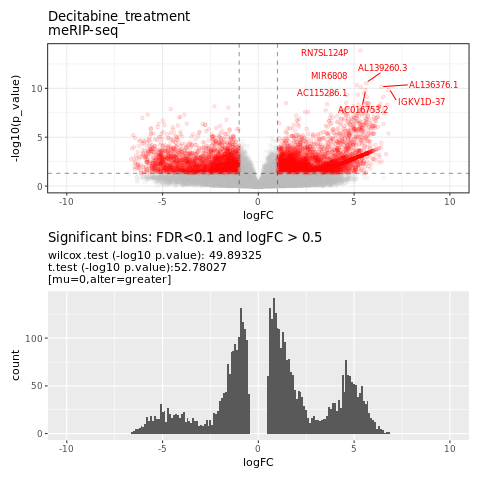

In [75]:
%%R 
res = read.table('radar/result.all.txt', header=TRUE,stringsAsFactors=FALSE)
res_sig = read.table('radar/result.sig.txt', header=TRUE,stringsAsFactors=FALSE)

vol = plot_Volcano (res, 'Decitabine_treatment\nmeRIP-seq')
his2 = plot_Hist(res_sig, 'Significant bins: FDR<0.1 and logFC > 0.5')



plot_Save(vol / his2, 'plots/d_mtyl_T_vs_U')
vol / his2

In [1]:
cat radar/result.all.txt | head 

chr	start	end	name	score	strand	thickStart	thickEnd	itemRgb	blockCount	blockSizes	blockStarts	logFC	p_value	ensembl
chr1	169853471	169853670	DDX11L1	0	-	169853471	169853670	0	1	199	0	4.80402104868872	0.00527072405006074	ENSG00000000457.14
chr1	169853771	169854317	DDX11L1	0	-	169853771	169854317	0	2	2,48	0,499	-1.45225232891169	0.533603309310244	ENSG00000000457.14
chr1	169854567	169854616	DDX11L1	0	-	169854567	169854616	0	1	49	0	0.368560551172713	0.799761282585567	ENSG00000000457.14
chr1	169854717	169854815	DDX11L1	0	-	169854717	169854815	0	1	98	0	2.99573227355399	0.0636456352234194	ENSG00000000457.14
chr6	53498437	53498486	WASH7P	0	-	53498437	53498486	0	1	49	0	1.09289798740744	0.000167445799765797	ENSG00000001084.13
chr6	53498636	53498934	WASH7P	0	-	53498636	53498934	0	1	298	0	2.5039548401484	0.695796517006243	ENSG00000001084.13
chr6	53522503	53522552	WASH7P	0	-	53522503	53522552	0	1	49	0	2.09801792162745	0.253501334934136	ENSG00000001084.13
chr6	53544736	53544785	WASH7P	0	-	53544736	5

In [2]:
cat radar/d_mtyl_T_vs_U.txt | head 

ENSG00000000457	4.80402104868872
ENSG00000001084	1.09289798740744
ENSG00000001629	5.20948615284141
ENSG00000001629	0.950192283583678
ENSG00000002919	5.96100533962328
ENSG00000003393	0.830939338045324
ENSG00000003393	1.10279639519063
ENSG00000003393	-1.57365896834207
ENSG00000003400	4.97673374242057
ENSG00000003402	1.64690884386422
cat: write error: Broken pipe


In [78]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS: /rumi/shams/abe/anaconda3/envs/imRIP/radar/lib/R/lib/libRblas.so
LAPACK: /rumi/shams/abe/anaconda3/envs/imRIP/radar/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2            patchwork_1.0.0          
 [3] forcats_0.3.0             stringr_1.3.1            
 [5] dplyr_0.7.6               purrr_0.2.5              
 [7] readr_1.1.1       